# Fraud Detection with Deep Learning

### Author: Akalu Abraham

This project focuses on detecting fraudulent transactions using deep learning. It includes steps for data exploration, preprocessing, and building a robust deep learning model to identify fraud. 

Let’s dive into the details and make transactions safer!
---

Install Requirements

In [1]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Note: you may need to restart the kernel to use updated packages.


c:\Users\user\AppData\Local\Programs\Python\Python312\python.exe: No module named pip


In [4]:
from helper_functions import plot_loss_curves, make_confusion_matrix

ModuleNotFoundError: No module named 'helper_functions'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline

In [5]:
df = pd.read_csv('samp_online.csv')

In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136,160296.36,M1979787155,0,0.00,0,0
1,1,TRANSFER,181.00,C1305486145,181,0.00,C553264065,0,0.00,1,0
2,1,CASH_OUT,181.00,C840083671,181,0.00,C38997010,21182,0.00,1,0
3,1,DEBIT,5337.77,C712410124,41720,36382.23,C195600860,41898,40348.79,0,0
4,1,CASH_OUT,229133.94,C905080434,15325,0.00,C476402209,5083,51513.44,0,0


In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, explorative=True)
profile.to_notebook_iframe()

ModuleNotFoundError: No module named 'pandas_profiling'

In [10]:
df1 = df.copy()

In [11]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df1['amount'] = rs.fit_transform(df1['amount'].to_numpy().reshape(-1, 1))
df1['oldbalanceOrg'] = rs.fit_transform(df1['oldbalanceOrg'].to_numpy().reshape(-1, 1))
df1['newbalanceOrig'] = rs.fit_transform(df1['newbalanceOrig'].to_numpy().reshape(-1, 1))
df1['oldbalanceDest'] = rs.fit_transform(df1['oldbalanceDest'].to_numpy().reshape(-1, 1))
df1['newbalanceDest'] = rs.fit_transform(df1['newbalanceDest'].to_numpy().reshape(-1, 1))

array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'oldbalanceOrg'}>],
       [<Axes: title={'center': 'newbalanceOrig'}>,
        <Axes: title={'center': 'oldbalanceDest'}>,
        <Axes: title={'center': 'newbalanceDest'}>],
       [<Axes: title={'center': 'isFraud'}>,
        <Axes: title={'center': 'isFlaggedFraud'}>, <Axes: >]],
      dtype=object)

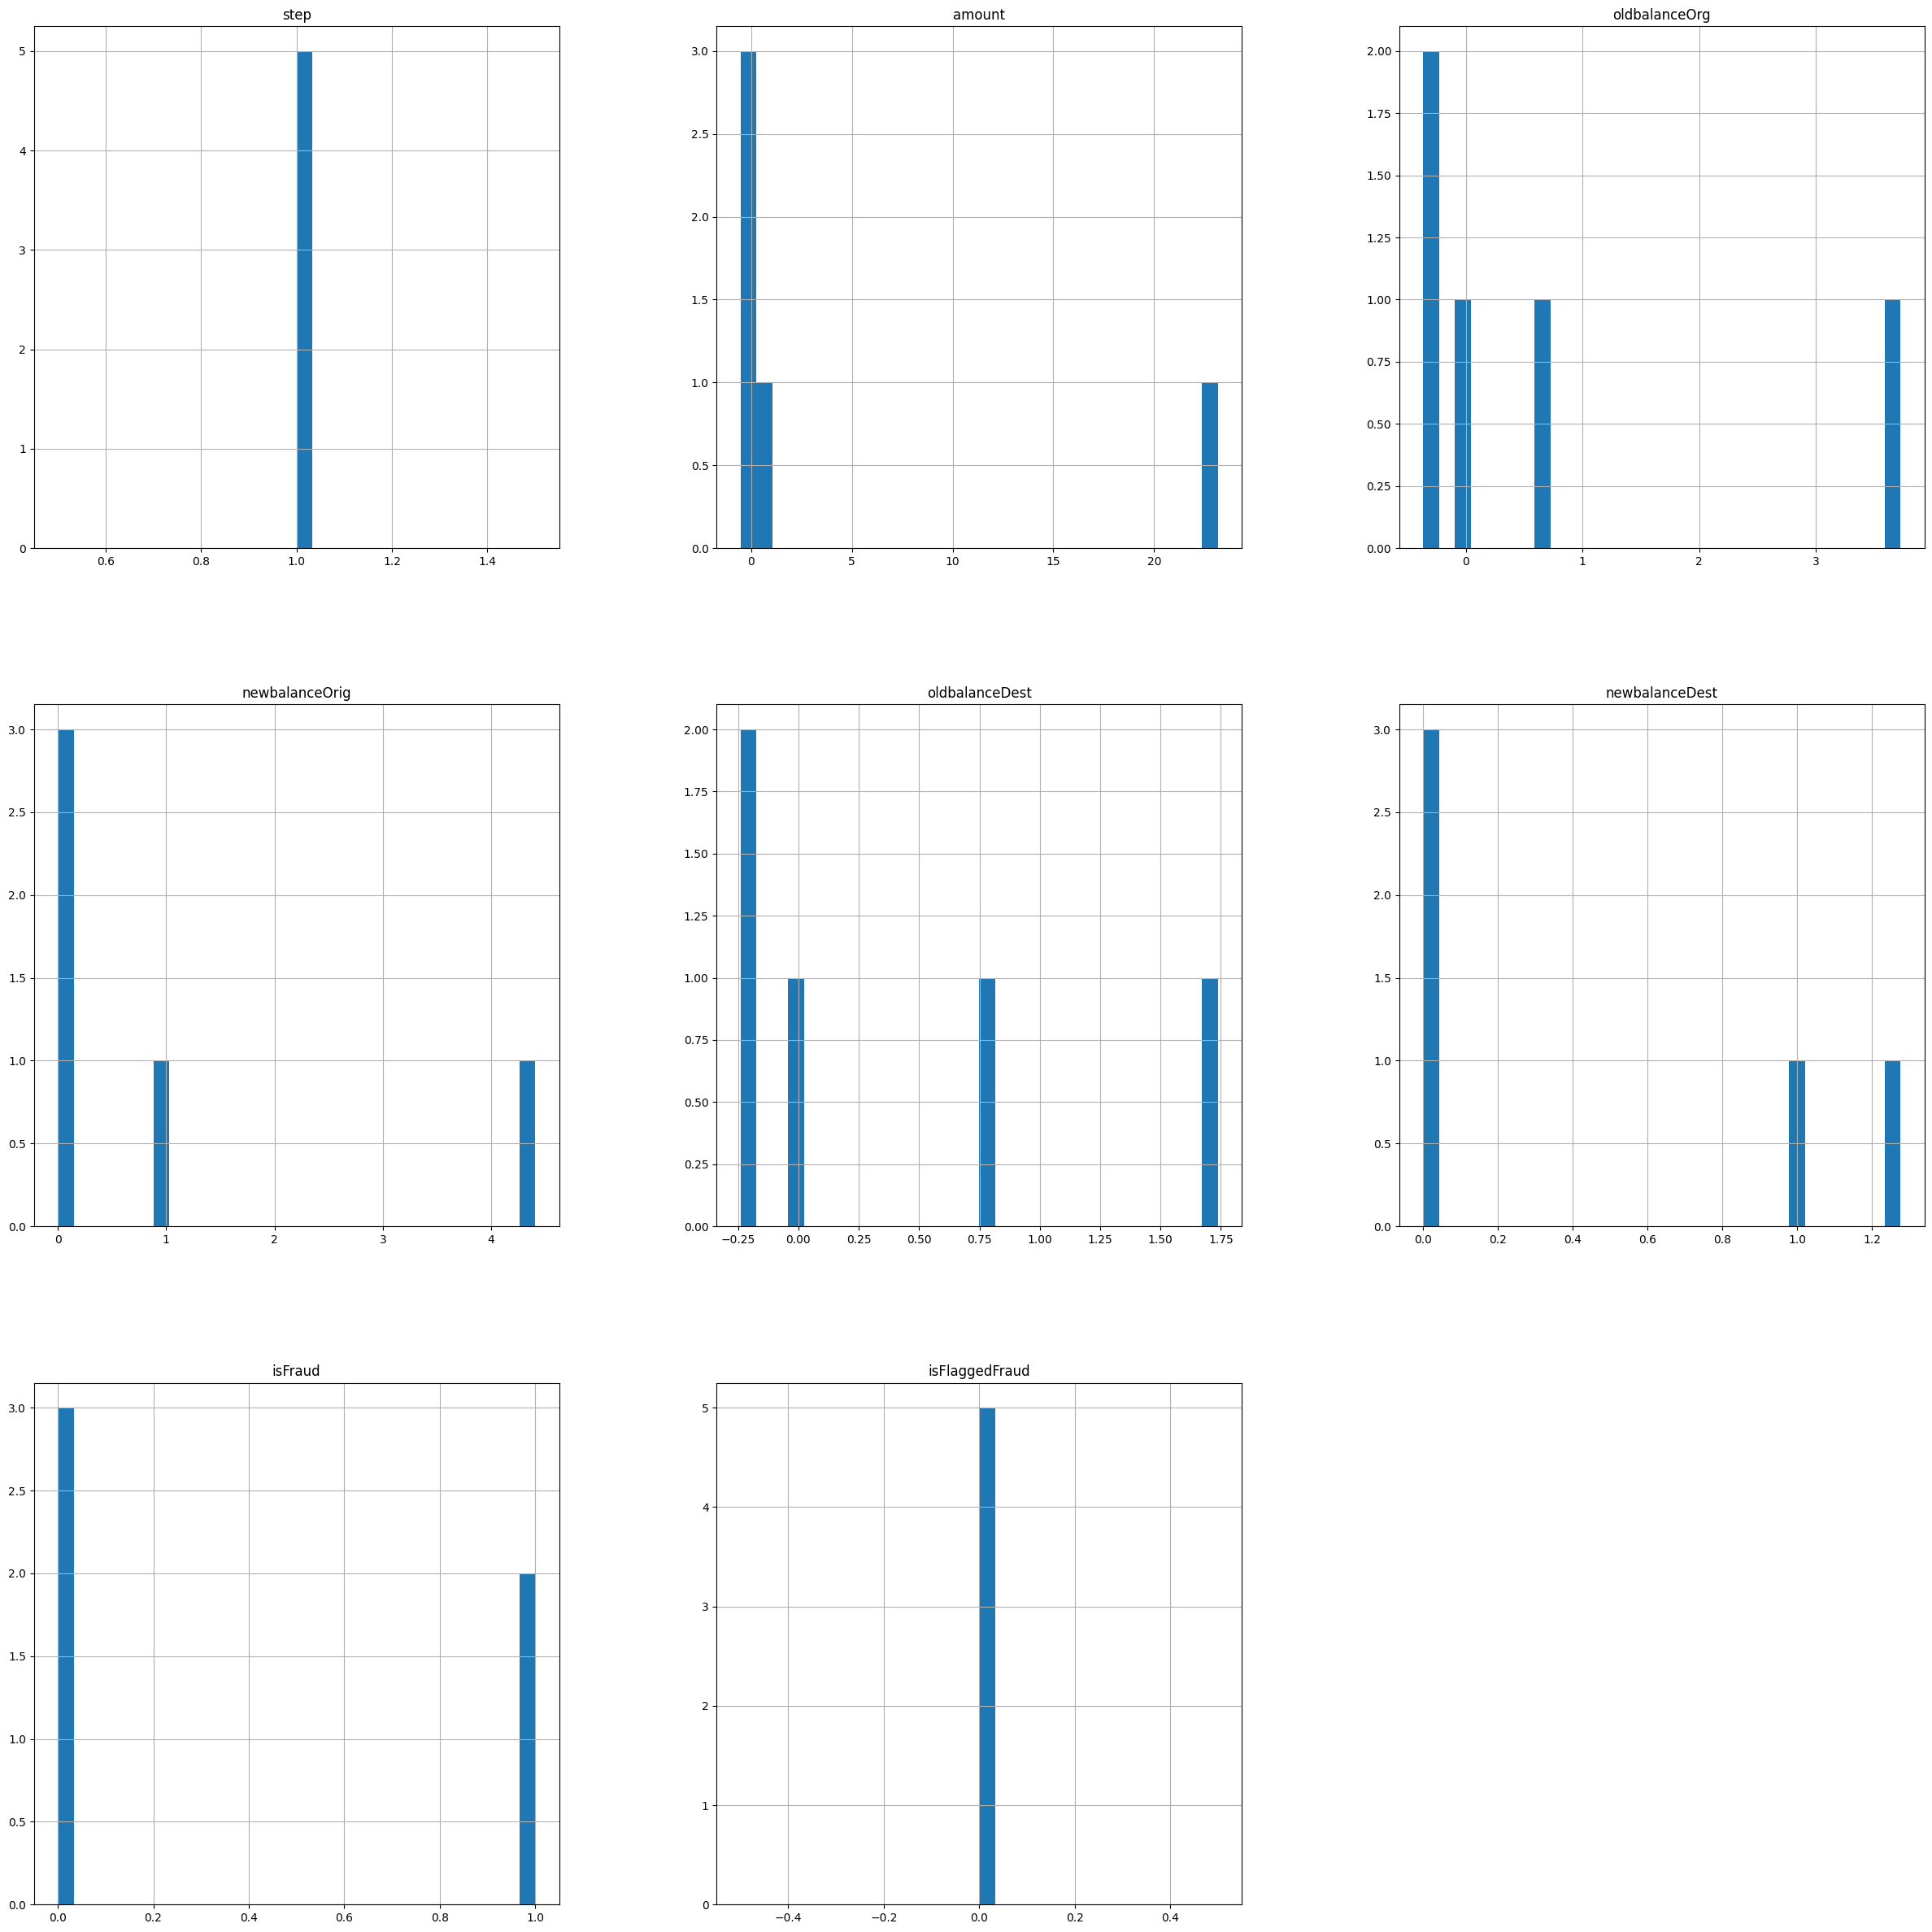

In [12]:
df1.hist(bins = 30, figsize=(30,30))

In [13]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,0.466098,C1231006815,3.726883,4.405897,M1979787155,-0.239968,0.000000,0,0
1,1,TRANSFER,-0.533902,C1305486145,-0.364573,0.000000,C553264065,-0.239968,0.000000,1,0
2,1,CASH_OUT,-0.533902,C840083671,-0.364573,0.000000,C38997010,0.760032,0.000000,1,0
3,1,DEBIT,0.000000,C712410124,0.635427,1.000000,C195600860,1.738032,1.000000,0,0
4,1,CASH_OUT,23.170567,C905080434,0.000000,0.000000,C476402209,0.000000,1.276703,0,0


In [14]:
df1.drop(['nameOrig','nameDest','isFlaggedFraud'], axis = 1, inplace = True)

In [15]:
df1 = pd.get_dummies(df1, columns = ['type'])

In [16]:
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,0.466098,3.726883,4.405897,-0.239968,0.000000,0,False,False,True,False
1,1,-0.533902,-0.364573,0.000000,-0.239968,0.000000,1,False,False,False,True
2,1,-0.533902,-0.364573,0.000000,0.760032,0.000000,1,True,False,False,False
3,1,0.000000,0.635427,1.000000,1.738032,1.000000,0,False,True,False,False
4,1,23.170567,0.000000,0.000000,0.000000,1.276703,0,True,False,False,False


In [17]:
df1['isFraud'].value_counts()

isFraud
0    3
1    2
Name: count, dtype: int64

In [18]:
not_frauds = df1.query('isFraud == 0')
frauds = df1.query('isFraud == 1')
not_frauds['isFraud'].value_counts(), frauds['isFraud'].value_counts()

(isFraud
 0    3
 Name: count, dtype: int64,
 isFraud
 1    2
 Name: count, dtype: int64)

## 6. Preparing Data for Modeling

Before training, we need to split our data and ensure it's in the right format. We'll also address **Isfraud** target variable imbalance using undersampling.

In [19]:
not_frauds = df1.query('isFraud == 0')
frauds = df1.query('isFraud == 1')
not_frauds['isFraud'].value_counts(), frauds['isFraud'].value_counts()

(isFraud
 0    3
 Name: count, dtype: int64,
 isFraud
 1    2
 Name: count, dtype: int64)

In [20]:
under_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
under_df['isFraud'].value_counts()

isFraud
1    2
0    2
Name: count, dtype: int64

In [21]:
X = under_df.drop(['isFraud'], axis = 1)
y = under_df['isFraud']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state = 42)

In [23]:
y_train.value_counts()

isFraud
0    2
1    1
Name: count, dtype: int64

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
sc =  MinMaxScaler()

# Fit on the training data
X_train.iloc[:, :6] = sc.fit_transform(X_train.iloc[:, :6])

# Transform the validation/test data
X_test.iloc[:, :6] = sc.transform(X_test.iloc[:, :6])

Deep Neural Network Architecture

In [25]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid')

])


model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

ValueError: Cannot convert '10' to a shape.

### Detailed Classification Report

For a more granular understanding of our model's performance, we'll use the `classification_report` from scikit-learn. This report will provide key metrics like precision, recall, and F1-score for each class.